In [156]:
# Core libraries
import pandas as pd
import numpy as np
import sqlite3
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (we’ll use later)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# Change to project root (adjust as needed)
os.chdir("C:/Projects/Emissions_Analysis_Capstone")

CO₂ Emissions Comparison (Total + Per Vehicle):


,Category,Total_CO2_kg_per_year,Total_CO2_million_tonnes_per_year,Per_Unit_CO2_kg_per_year
0,Cattle Meat (NA),5.782722e+10,57827.215356,NaN
1,"Vehicles (NA, 2015 sales)",1.006528e+10,10065.278941,576.13002


C:\Users\derek\AppData\Local\Temp\ipykernel_21972\3501279111.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


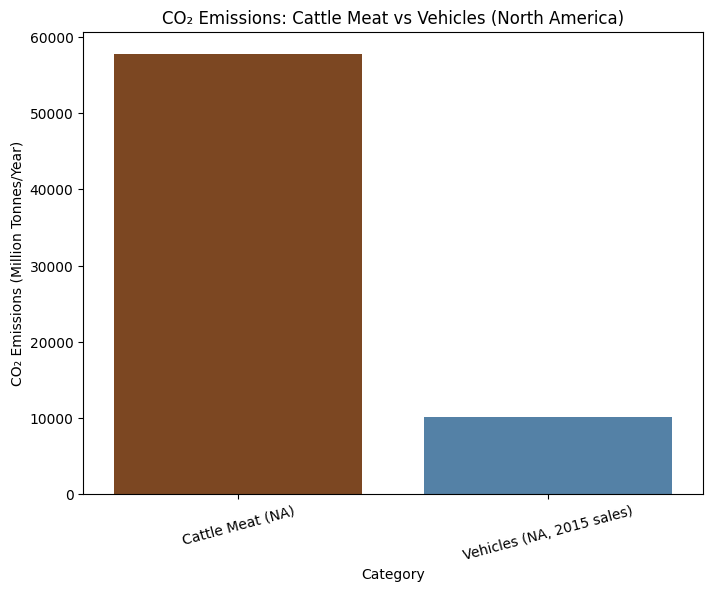

C:\Users\derek\AppData\Local\Temp\ipykernel_21972\3501279111.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


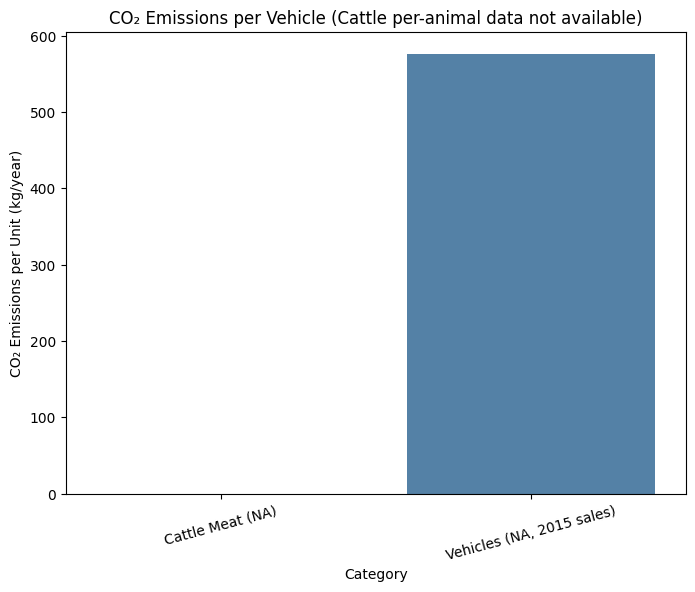

In [157]:
db_path = os.path.join('emissions_data', 'emissionsdata.sqlite')
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = sqlite3.connect(db_path)

# === Livestock query (without population column) ===
livestock_query = """
SELECT
    region,
    animal_type,
    commodity,
    co2_emissions_kg,
    n2o_emissions_kg
FROM livestock_emissions;
"""
livestock_df = pd.read_sql(livestock_query, conn)

# Filter livestock to North America, cattle, meat commodity
cattle_meat_na_df = livestock_df[
    (livestock_df["region"] == "North America") &
    (livestock_df["animal_type"] == "Cattle") &
    (livestock_df["commodity"] == "Meat")
].copy()

# Calculate total cattle CO2 emissions
cattle_total_CO2_kg = cattle_meat_na_df["co2_emissions_kg"].sum()
cattle_total_CO2_million_tonnes = cattle_total_CO2_kg / 1e6

# === Vehicle query ===
vehicle_query = """
SELECT
    make,
    model,
    co2_emissions_g_per_km,
    fuel_type
FROM vehicle_emissions;
"""
vehicle_df = pd.read_sql(vehicle_query, conn)

# Convert CO2 column to numeric
vehicle_df["co2_emissions_g_per_km"] = pd.to_numeric(
    vehicle_df["co2_emissions_g_per_km"], errors="coerce"
)

# Convert g/km → kg/km
vehicle_df["co2_emissions_kg_per_km"] = vehicle_df["co2_emissions_g_per_km"] / 1000

# Multiply by average annual mileage to get kg/year
AVG_KM_PER_YEAR = 16094  # 10,000 miles
vehicle_df["co2_emissions_kg_per_year"] = vehicle_df["co2_emissions_kg_per_km"] * AVG_KM_PER_YEAR

# Dataset aggregates 7 years, divide by NUM_YEARS to get avg per year
NUM_YEARS = 7
vehicle_df["co2_emissions_kg_per_year"] = vehicle_df["co2_emissions_kg_per_year"] / NUM_YEARS

# Total vehicles sold in 2015 (NA)
TOTAL_VEHICLES_2015 = 17_470_499
vehicle_total_CO2_kg_2015 = vehicle_df["co2_emissions_kg_per_year"].mean() * TOTAL_VEHICLES_2015
vehicle_total_CO2_million_tonnes = vehicle_total_CO2_kg_2015 / 1e6

# CO2 per vehicle per year
vehicle_CO2_per_vehicle_kg_per_year = vehicle_df["co2_emissions_kg_per_year"].mean()

# === Summary comparison (totals + per-vehicle) ===
summary_df = pd.DataFrame({
    "Category": ["Cattle Meat (NA)", "Vehicles (NA, 2015 sales)"],
    "Total_CO2_kg_per_year": [cattle_total_CO2_kg, vehicle_total_CO2_kg_2015],
    "Total_CO2_million_tonnes_per_year": [cattle_total_CO2_million_tonnes, vehicle_total_CO2_million_tonnes],
    "Per_Unit_CO2_kg_per_year": [None, vehicle_CO2_per_vehicle_kg_per_year]
})

print("CO₂ Emissions Comparison (Total + Per Vehicle):")
display(summary_df)

# === Visualization: Total emissions ===
plt.figure(figsize=(8,6))
sns.barplot(
    x="Category",
    y="Total_CO2_million_tonnes_per_year",
    data=summary_df,
    palette=["saddlebrown", "steelblue"]
)
plt.ylabel("CO₂ Emissions (Million Tonnes/Year)")
plt.title("CO₂ Emissions: Cattle Meat vs Vehicles (North America)")
plt.xticks(rotation=15)
plt.show()

# === Visualization: Per-vehicle emissions ===
plt.figure(figsize=(8,6))
sns.barplot(
    x="Category",
    y="Per_Unit_CO2_kg_per_year",
    data=summary_df,
    palette=["saddlebrown", "steelblue"]
)
plt.ylabel("CO₂ Emissions per Unit (kg/year)")
plt.title("CO₂ Emissions per Vehicle (Cattle per-animal data not available)")
plt.xticks(rotation=15)
plt.show()

In [158]:
# --- Livestock CO2 statistics ---
print("=== Livestock CO2 Emissions (kg/year) ===")
livestock_stats = livestock_df["co2_emissions_kg"].describe()
display(livestock_stats)

# --- Vehicle CO2 statistics ---
print("\n=== Vehicle CO2 Emissions (kg/year) ===")
vehicle_stats = vehicle_df["co2_emissions_kg_per_year"].describe()
display(vehicle_stats)

=== Livestock CO2 Emissions (kg/year) ===


count    5.830000e+02
mean     2.547730e+10
std      8.311139e+10
min      0.000000e+00
25%      1.509816e+08
50%      1.882964e+09
75%      1.089344e+10
max      9.449299e+11
Name: co2_emissions_kg, dtype: float64


=== Vehicle CO2 Emissions (kg/year) ===


count    7385.000000
mean      576.130020
std       134.529009
min       220.717714
25%       478.221714
50%       565.589143
75%       662.153143
max      1200.152571
Name: co2_emissions_kg_per_year, dtype: float64

C:\Users\derek\AppData\Local\Temp\ipykernel_21972\1520327501.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


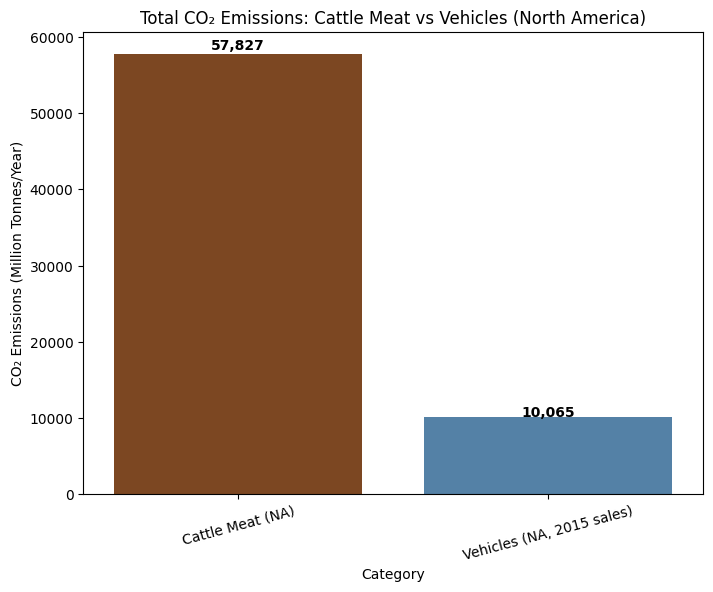

In [159]:
plt.figure(figsize=(8,6))
sns.barplot(
    x="Category",
    y="Total_CO2_million_tonnes_per_year",
    data=summary_df,
    palette=["saddlebrown", "steelblue"]
)
plt.ylabel("CO₂ Emissions (Million Tonnes/Year)")
plt.title("Total CO₂ Emissions: Cattle Meat vs Vehicles (North America)")
plt.xticks(rotation=15)
for i, v in enumerate(summary_df["Total_CO2_million_tonnes_per_year"]):
    plt.text(i, v*1.01, f"{v:,.0f}", ha='center', fontweight='bold')
plt.show()

C:\Users\derek\AppData\Local\Temp\ipykernel_21972\2981108978.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


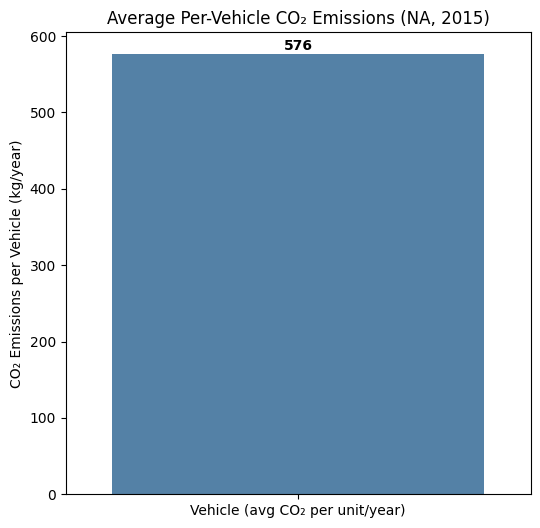

In [160]:
plt.figure(figsize=(6,6))
sns.barplot(
    x=["Vehicle (avg CO₂ per unit/year)"],
    y=[vehicle_CO2_per_vehicle_kg_per_year],
    palette=["steelblue"]
)
plt.ylabel("CO₂ Emissions per Vehicle (kg/year)")
plt.title("Average Per-Vehicle CO₂ Emissions (NA, 2015)")
plt.text(0, vehicle_CO2_per_vehicle_kg_per_year*1.01, f"{vehicle_CO2_per_vehicle_kg_per_year:,.0f}", ha='center', fontweight='bold')
plt.show()

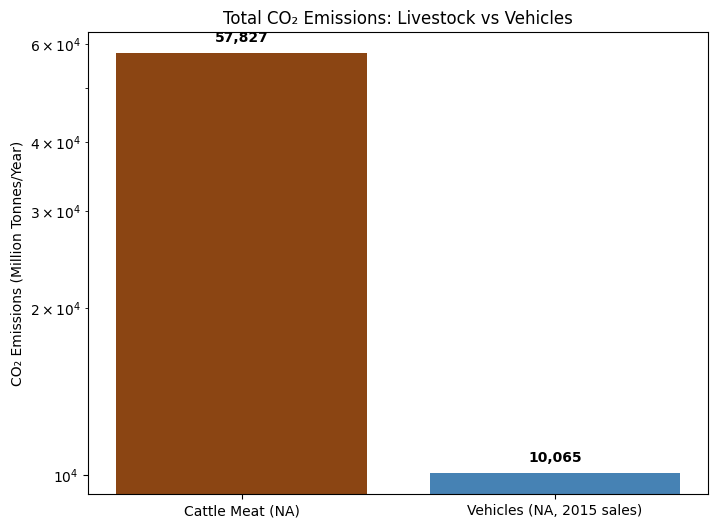

In [161]:
plt.figure(figsize=(8,6))
totals = [cattle_total_CO2_million_tonnes, vehicle_total_CO2_million_tonnes]
labels = ["Cattle Meat (NA)", "Vehicles (NA, 2015 sales)"]
colors = ["saddlebrown", "steelblue"]

plt.bar(labels, totals, color=colors)
plt.ylabel("CO₂ Emissions (Million Tonnes/Year)")
plt.title("Total CO₂ Emissions: Livestock vs Vehicles")
plt.yscale("log")  # optional, log scale to handle huge differences
for i, v in enumerate(totals):
    plt.text(i, v*1.05, f"{v:,.0f}", ha='center', fontweight='bold')
plt.show()

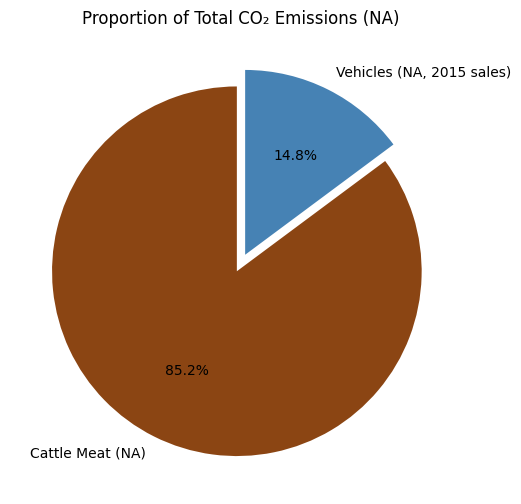

In [162]:
plt.figure(figsize=(6,6))
plt.pie(
    totals,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    explode=(0.05, 0.05)
)
plt.title("Proportion of Total CO₂ Emissions (NA)")
plt.show()

In [163]:
# --- Encode categorical variables ---
vehicle_model_df = vehicle_df.copy()
vehicle_model_df = pd.get_dummies(vehicle_model_df, columns=["fuel_type", "make"], drop_first=True)

# --- Define features and target ---
X = vehicle_model_df.drop(columns=["model", "co2_emissions_g_per_km", "co2_emissions_kg_per_km", "co2_emissions_kg_per_year"])
y = vehicle_model_df["co2_emissions_g_per_km"]

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Fit Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)

# --- Predict ---
y_pred = lr.predict(X_test)

# --- Evaluate ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Linear Regression R²: {r2:.2f}")

Linear Regression RMSE: 46.55
Linear Regression R²: 0.37


In [164]:
# Assume vehicle_model_df is already one-hot encoded
X = vehicle_model_df.drop(columns=["model", "co2_emissions_g_per_km",
                                   "co2_emissions_kg_per_km", "co2_emissions_kg_per_year"])
y = vehicle_model_df["co2_emissions_g_per_km"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R²: {r2:.2f}")

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances.head(10)

Random Forest RMSE: 45.39
Random Forest R²: 0.40


fuel_type_X         0.166882
make_GMC            0.093432
make_MINI           0.085488
make_ROLLS-ROYCE    0.066423
make_LAMBORGHINI    0.063380
make_BENTLEY        0.041133
make_CHEVROLET      0.038497
make_FORD           0.038239
make_DODGE          0.036421
make_RAM            0.035943
dtype: float64

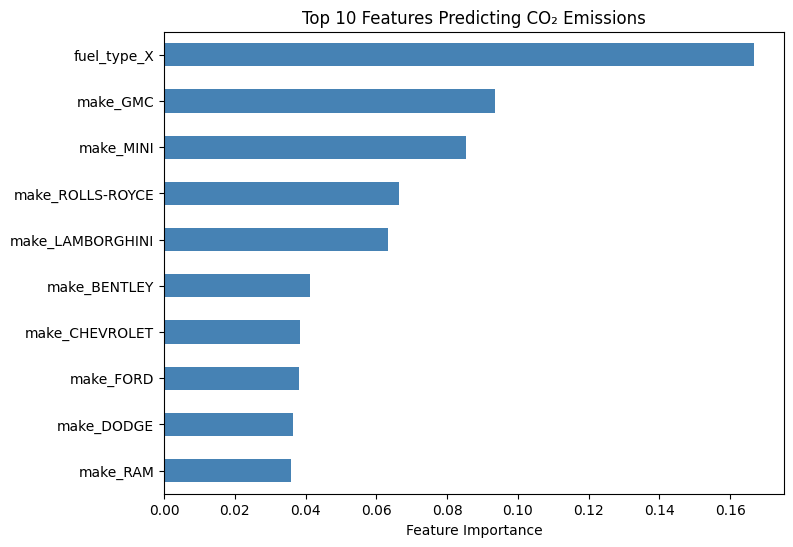

In [165]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
top_features.plot(kind='barh', color='steelblue')
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel("Feature Importance")
plt.title("Top 10 Features Predicting CO₂ Emissions")
plt.show()

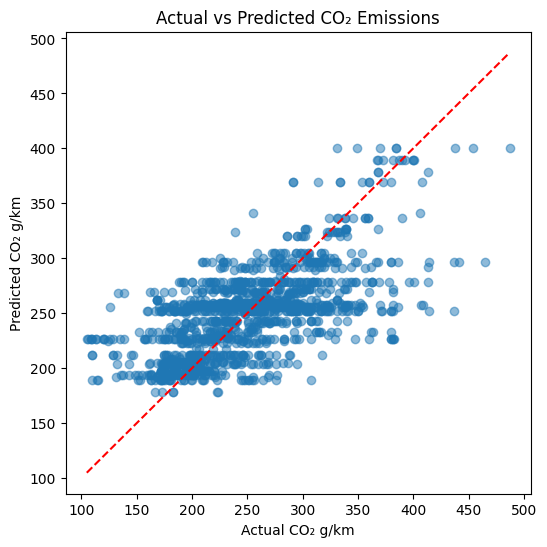

In [166]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CO₂ g/km")
plt.ylabel("Predicted CO₂ g/km")
plt.title("Actual vs Predicted CO₂ Emissions")
plt.show()

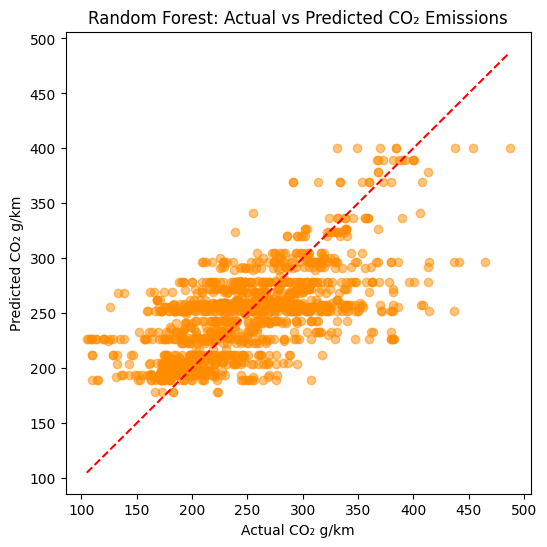

In [167]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CO₂ g/km")
plt.ylabel("Predicted CO₂ g/km")
plt.title("Random Forest: Actual vs Predicted CO₂ Emissions")
plt.show()

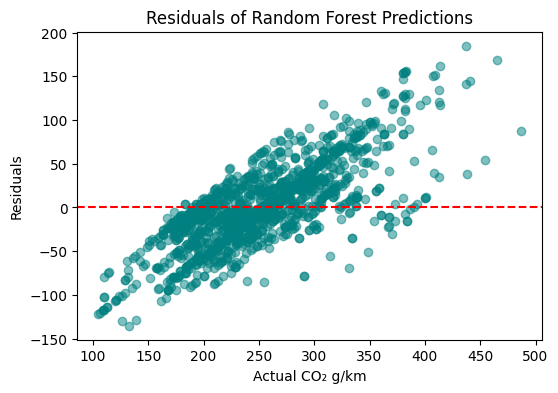

In [168]:
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_test, residuals, alpha=0.5, color='teal')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Actual CO₂ g/km")
plt.ylabel("Residuals")
plt.title("Residuals of Random Forest Predictions")
plt.show()

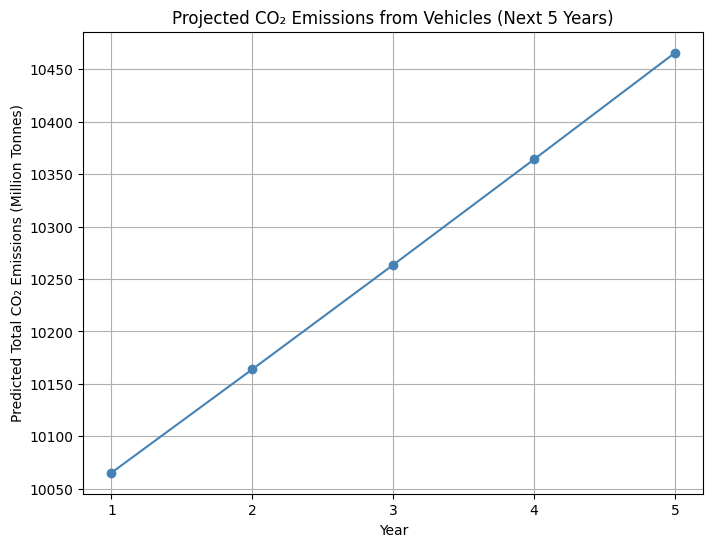

In [169]:
NUM_YEARS = 5
annual_fleet_growth = 0.02     # 2% increase in number of vehicles/year
annual_efficiency_improve = 0.01  # 1% decrease in CO2 per km/year

# Baseline average per-vehicle CO2 (kg/year)
baseline_co2_per_vehicle = vehicle_df["co2_emissions_kg_per_year"].mean()

# Baseline fleet size (number of vehicles)
fleet_size = 17470500  # example: 2015 North America sales

# Initialize list to store yearly predictions
predicted_total_co2 = []

for year in range(NUM_YEARS):
    # Apply fleet growth
    fleet_size_year = fleet_size * ((1 + annual_fleet_growth) ** year)

    # Apply efficiency improvements
    co2_per_vehicle_year = baseline_co2_per_vehicle * ((1 - annual_efficiency_improve) ** year)

    # Total emissions
    total_co2_year = fleet_size_year * co2_per_vehicle_year
    predicted_total_co2.append(total_co2_year / 1e6)  # convert to million tonnes

    years = np.arange(1, NUM_YEARS + 1)  # Year 1, Year 2, ...
plt.figure(figsize=(8,6))
plt.plot(years, predicted_total_co2, marker='o', linestyle='-', color='steelblue')
plt.xticks(years)
plt.ylabel("Predicted Total CO₂ Emissions (Million Tonnes)")
plt.xlabel("Year")
plt.title("Projected CO₂ Emissions from Vehicles (Next 5 Years)")
plt.grid(True)
plt.show()

c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted

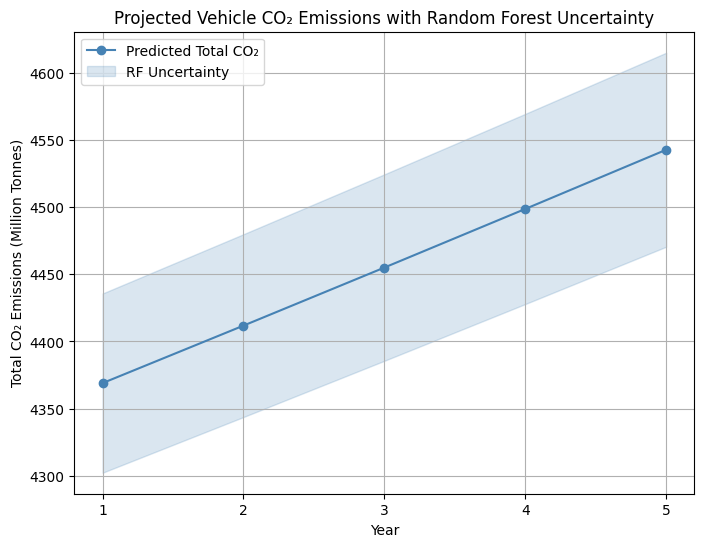

In [170]:
# Assuming 'rf' is your trained RandomForestRegressor
# X_baseline contains features for all vehicles (or average vehicle)
# Here we just use the average vehicle features for simplicity

# Compute predictions for each tree
all_tree_preds = np.array([tree.predict(X_test) for tree in rf.estimators_])

# Compute mean and standard deviation per sample
mean_preds = np.mean(all_tree_preds, axis=0)
std_preds = np.std(all_tree_preds, axis=0)

# Use mean of the mean_preds as baseline per-vehicle CO2
baseline_co2_per_vehicle = np.mean(mean_preds)  # kg/year

NUM_YEARS = 5
annual_fleet_growth = 0.02     # 2% increase per year
annual_efficiency_improve = 0.01  # 1% per year improvement
fleet_size = 17470500  # 2015 NA sales

predicted_total_co2 = []
upper_bound = []
lower_bound = []

for year in range(NUM_YEARS):
    fleet_year = fleet_size * ((1 + annual_fleet_growth) ** year)
    co2_per_vehicle_year = baseline_co2_per_vehicle * ((1 - annual_efficiency_improve) ** year)

    total_co2_year = fleet_year * co2_per_vehicle_year
    predicted_total_co2.append(total_co2_year / 1e6)  # convert to million tonnes

    # Uncertainty bounds
    upper_bound.append((total_co2_year + std_preds.mean() * fleet_year) / 1e6)
    lower_bound.append((total_co2_year - std_preds.mean() * fleet_year) / 1e6)

    years = np.arange(1, NUM_YEARS + 1)

plt.figure(figsize=(8,6))
plt.plot(years, predicted_total_co2, marker='o', color='steelblue', label="Predicted Total CO₂")
plt.fill_between(years, lower_bound, upper_bound, color='steelblue', alpha=0.2, label="RF Uncertainty")
plt.xticks(years)
plt.ylabel("Total CO₂ Emissions (Million Tonnes)")
plt.xlabel("Year")
plt.title("Projected Vehicle CO₂ Emissions with Random Forest Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted

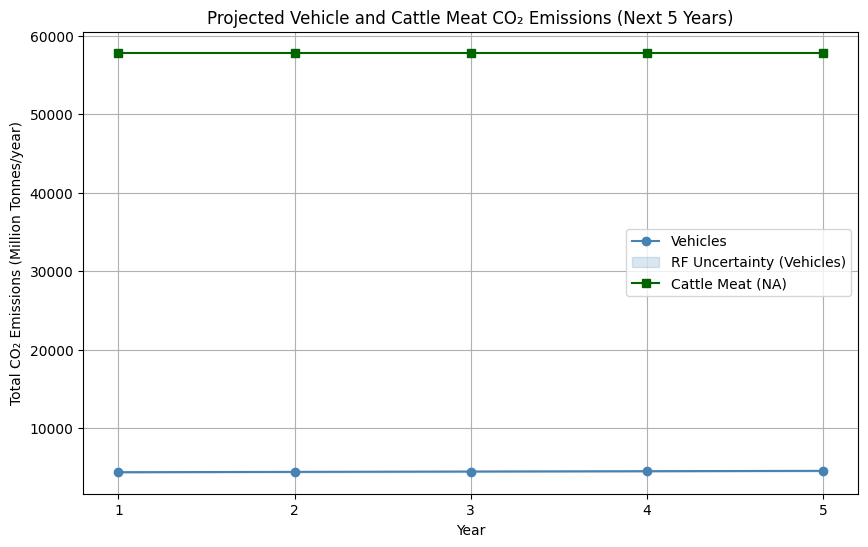

In [172]:
# --- Assumptions ---
NUM_YEARS = 5
annual_vehicle_growth = 0.02         # 2% annual vehicle fleet growth
annual_efficiency_improve = 0.01     # 1% per year efficiency improvement
vehicle_fleet_2015 = 17470500        # 2015 North America vehicle sales

# Filter livestock for North America, Cattle, Meat
cattle_meat_na_df = livestock_df[
    (livestock_df["region"] == "North America") &
    (livestock_df["animal_type"] == "Cattle") &
    (livestock_df["commodity"] == "Meat")
].copy()

# Compute total CO2 (kg/year) and convert to million tonnes
livestock_total_co2 = cattle_meat_na_df["co2_emissions_kg"].sum() / 1e6  # million tonnes
livestock_total_list = [livestock_total_co2] * NUM_YEARS  # repeat for 5 years

# --- Compute Random Forest uncertainty for per-vehicle CO2 ---
# X_test is your vehicle features used previously
all_tree_preds = np.array([tree.predict(X_test) for tree in rf.estimators_])
mean_preds = np.mean(all_tree_preds, axis=0)
std_preds = np.std(all_tree_preds, axis=0)
baseline_co2_per_vehicle = np.mean(mean_preds)  # kg/year

# --- Initialize vehicle lists ---
vehicle_total_co2 = []
vehicle_upper = []
vehicle_lower = []
years = np.arange(1, NUM_YEARS + 1)

for year in range(NUM_YEARS):
    # Vehicle projections
    fleet_year = vehicle_fleet_2015 * ((1 + annual_vehicle_growth) ** year)
    co2_per_vehicle_year = baseline_co2_per_vehicle * ((1 - annual_efficiency_improve) ** year)
    total_co2_year = fleet_year * co2_per_vehicle_year
    vehicle_total_co2.append(total_co2_year / 1e6)  # million tonnes

    # Uncertainty bounds
    vehicle_upper.append((total_co2_year + std_preds.mean() * fleet_year) / 1e6)
    vehicle_lower.append((total_co2_year - std_preds.mean() * fleet_year) / 1e6)

# --- Plot combined projections ---
plt.figure(figsize=(10,6))

# Vehicle trendline with uncertainty
plt.plot(years, vehicle_total_co2, color='steelblue', marker='o', label="Vehicles")
plt.fill_between(years, vehicle_lower, vehicle_upper, color='steelblue', alpha=0.2, label="RF Uncertainty (Vehicles)")

# Livestock trendline
plt.plot(years, livestock_total_list, color='darkgreen', marker='s', label="Cattle Meat (NA)")

plt.xticks(years)
plt.ylabel("Total CO₂ Emissions (Million Tonnes/year)")
plt.xlabel("Year")
plt.title("Projected Vehicle and Cattle Meat CO₂ Emissions (Next 5 Years)")
plt.legend()
plt.grid(True)
plt.show()